 ### Importing required libraries

In [1]:
import wave
import numpy as np  
from pathlib import Path
from IPython.display import Audio, display  
import librosa  
import librosa.display 
import matplotlib.pyplot as plt
import torchaudio
import torch

In [2]:
import sys
import os
# Access Script and Data directory
script_path = os.path.abspath(os.path.join(os.getcwd(), '...','scripts' ))
data_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'data'))
sys.path.append(script_path)
# sys.path.append(data_path)

In [3]:
script_path

'd:\\PERSONAL\\GitHub\\College\\MOTIVE\\backend\\notebooks\\...\\scripts'

In [4]:
data_path

'd:\\PERSONAL\\GitHub\\College\\MOTIVE\\backend\\data'

### Recording the audio from Microphone

Importing required libraries

In [6]:
import pyaudio  # type: ignore

Audio Parameters

In [7]:
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 16000
CHUNK = 4000
frames = []

Directory File paths

In [8]:
audio_folder=data_path+r"\audio"
recorded_audio_path = audio_folder +r"\recorded_audio.wav"


In [9]:
audio_folder

'd:\\PERSONAL\\GitHub\\College\\MOTIVE\\backend\\data\\audio'

 Make Output Folder

In [10]:
parent_dir = Path(audio_folder)
parent_dir.mkdir(parents=True, exist_ok=True)


Initialize PyAudio for recording

In [11]:
p = pyaudio.PyAudio()

Record Audio

In [12]:
stream = p.open(format=FORMAT, channels=CHANNELS, rate=RATE, input=True, frames_per_buffer=CHUNK)
print("🎤 Recording audio... Press the stop button or interrupt the kernel to stop.")
try:
    while True:
        data = stream.read(CHUNK)
        frames.append(data)
except KeyboardInterrupt:
    print("⏹ Recording stopped.")
finally:
    stream.stop_stream()
    stream.close()
    p.terminate()
    print("✅ Recording finished.")

🎤 Recording audio... Press the stop button or interrupt the kernel to stop.
⏹ Recording stopped.
✅ Recording finished.


Saving the recorded audio file

In [13]:
with wave.open(str(recorded_audio_path), "wb") as wf:
        wf.setnchannels(CHANNELS)
        wf.setsampwidth(p.get_sample_size(FORMAT))
        wf.setframerate(RATE)
        wf.writeframes(b"".join(frames))
print(f"✅ Audio saved to {recorded_audio_path}")

✅ Audio saved to d:\PERSONAL\GitHub\College\MOTIVE\backend\data\audio\recorded_audio.wav


Playing recorded audio

In [14]:
print("▶️ Playing recorded audio...")
display(Audio(str(recorded_audio_path), rate=RATE))


▶️ Playing recorded audio...


Closeing the micrphone and pyaudio

In [15]:
p.terminate()

### Loading from local drive

Audio file paths

In [16]:
input_audio_path = audio_folder+r'\source_0.wav'

Load the audio file and display it

In [17]:
input_audio, sr = torchaudio.load(input_audio_path)
print(input_audio.shape)
print(sr)


torch.Size([1, 117480])
8000


Display the audio file

In [18]:
display(Audio(str(input_audio_path), rate=sr))


### Preprocessing the Audio

In [22]:
#type: ignore
# import audio_pipeline

In [23]:
# type: ignore
from pedalboard import *
import noisereduce as nr
import sounddevice as sd

In [24]:
def load_audio(input_data, sample_rate=None):
    if isinstance(input_data, str):
        audio, sr = torchaudio.load(input_data, normalize=True)
        print(f"Loaded audio - Shape: {audio.shape}, SR: {sr}, Duration: {audio.shape[1]/sr:.2f}s")
        return audio.numpy(), sr
    elif isinstance(input_data, (np.ndarray, torch.Tensor)):
        return np.array(input_data), sample_rate
    else:
        raise ValueError("Unsupported input type.")

In [25]:
# type: ignore
def enhance(audio,sr=None):
    # Apply noise reduction
    reduced_noise = nr.reduce_noise(y=audio, sr=sr, stationary=True, prop_decrease=0.75)

    # Apply effects using Pedalboard
    board = Pedalboard([
        NoiseGate(threshold_db=-30, ratio=1.5, release_ms=250),
        Compressor(threshold_db=-16, ratio=2.5),
        LowShelfFilter(cutoff_frequency_hz=400, gain_db=10, q=1),
        Gain(gain_db=10)
    ])

    effected = board(reduced_noise, sr)
    return effected

In [26]:
def main(input_data,sr=None):
    # Load audio
    audio, sr = load_audio(input_data)
    enhanced_audio = enhance(audio,sr)
    
    return enhanced_audio,sr

Preprocess the audio file and initialize the parameters

In [27]:
filename = os.path.basename(input_audio_path)
enhace_audio_path= audio_folder+r'\enhaced_'+filename

In [28]:
enhace_audio,sr=main(input_audio_path) 

Loaded audio - Shape: torch.Size([1, 117480]), SR: 8000, Duration: 14.69s


In [29]:
# Convert to tensor
effected_tensor = torch.tensor(enhace_audio)
# Save enhanced audio
torchaudio.save(enhace_audio_path, effected_tensor, sr)

In [30]:
print(enhace_audio.shape)

(1, 117480)


In [31]:
display(Audio(str(enhace_audio_path), rate=sr))

### Comparing the audio Files

In [32]:
display(Audio(str(input_audio_path), rate=sr))

In [33]:
display(Audio(str(enhace_audio_path), rate=sr))

In [34]:
input_audio,sr=librosa.load(input_audio_path, sr=sr)
enhace_audio,sr=librosa.load(enhace_audio_path, sr=sr)

In [35]:
input_audio.shape

(117480,)

In [36]:
enhace_audio.shape

(117480,)

Text(0.5, 1.0, 'Original Audio')

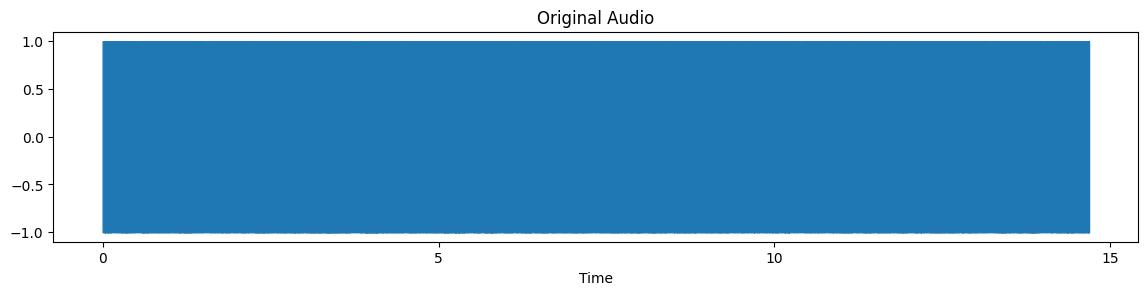

In [37]:
plt.figure(figsize=(14, 6))
plt.subplot(2, 1, 1)
librosa.display.waveshow(input_audio, sr=sr)
plt.title('Original Audio')

Text(0.5, 1.0, 'Enhanced Audio')

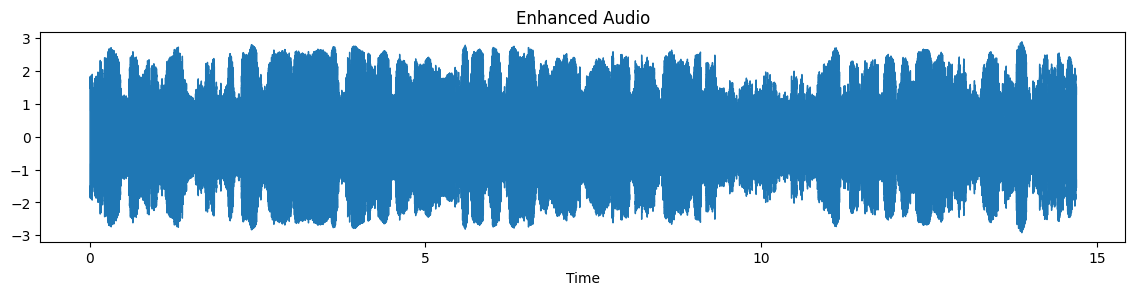

In [38]:
plt.figure(figsize=(14, 6))
plt.subplot(2, 1, 2)
librosa.display.waveshow(enhace_audio , sr=sr)
plt.title('Enhanced Audio')

Text(0.5, 1.0, 'Spectrogram - Original Audio')

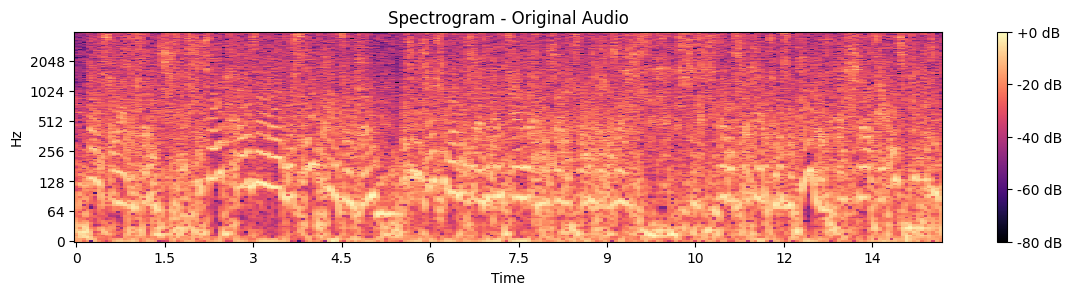

In [39]:
plt.figure(figsize=(14, 6))
plt.subplot(2, 1, 1)
D1 = librosa.amplitude_to_db(np.abs(librosa.stft(input_audio)), ref=np.max)
librosa.display.specshow(D1, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram - Original Audio')

Text(0.5, 1.0, 'Spectrogram - Enhanced Audio')

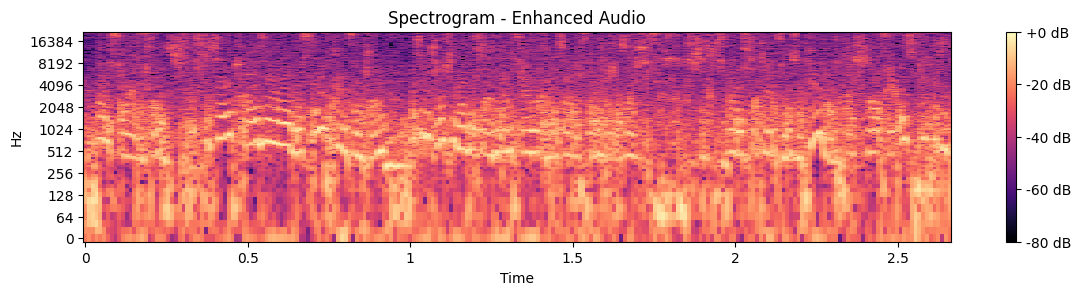

In [40]:
plt.figure(figsize=(14, 6))
plt.subplot(2, 1, 2)
D2 = librosa.amplitude_to_db(np.abs(librosa.stft(enhace_audio)), ref=np.max)
librosa.display.specshow(D2, sr=44100, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram - Enhanced Audio')

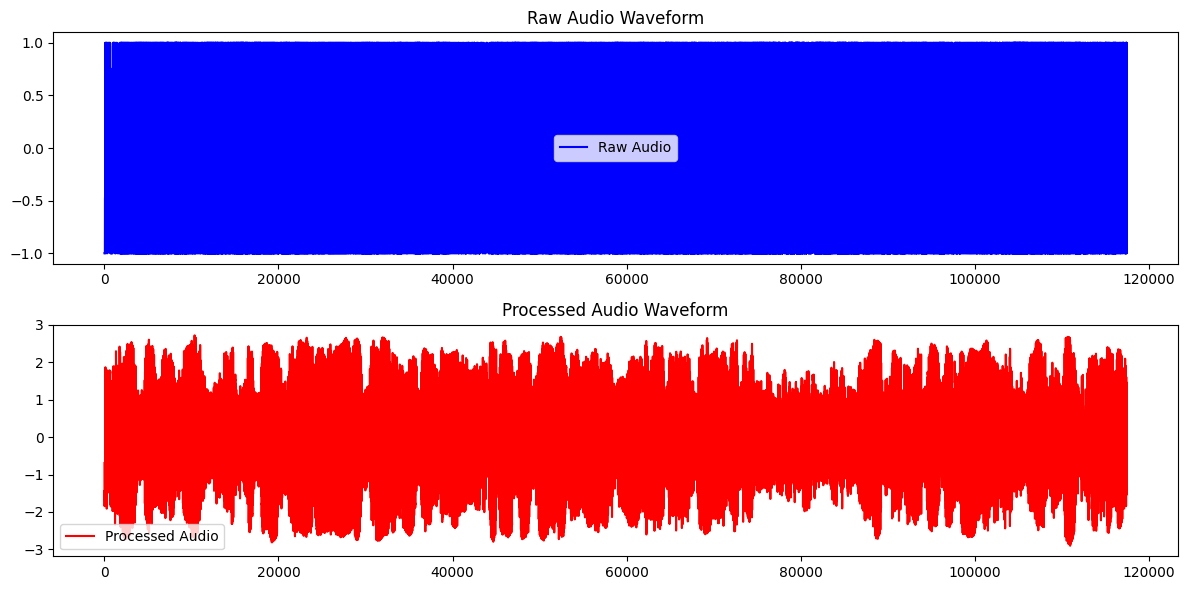

In [41]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(input_audio, label="Raw Audio", color='blue')
plt.title("Raw Audio Waveform")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(enhace_audio, label="Processed Audio", color='red')
plt.title("Processed Audio Waveform")
plt.legend()

plt.tight_layout()
plt.show()

### Audio components

In [42]:
#type: ignore
import pandas as pd

In [43]:
display(Audio(str(input_audio_path), rate=sr))

In [44]:
display(Audio(str(enhace_audio_path), rate=sr))

In [45]:
input_audio,sr=librosa.load(input_audio_path, sr=sr)
print(f"y:{input_audio[:10]}")
print(f"shape:{input_audio.shape}")
print(f"sr:{sr}")

y:[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
shape:(117480,)
sr:8000


In [46]:
enhace_audio,sr=librosa.load(enhace_audio_path, sr=16000)
print(f"y:{enhace_audio[:10]}")
print(f"shape:{enhace_audio.shape}")
print(f"sr:{sr}")

y:[-0.68093723 -0.85411346 -0.8564315  -0.85927033 -0.95202523 -1.0662217
 -1.1295773  -1.1749986  -1.2585576  -1.3602144 ]
shape:(234960,)
sr:16000


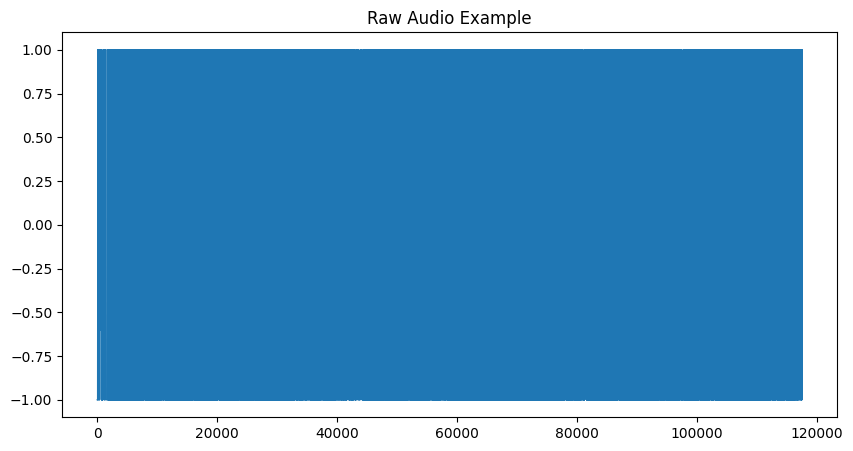

In [47]:
pd.Series(input_audio).plot(figsize=(10, 5), lw=1,title='Raw Audio Example')
plt.show()

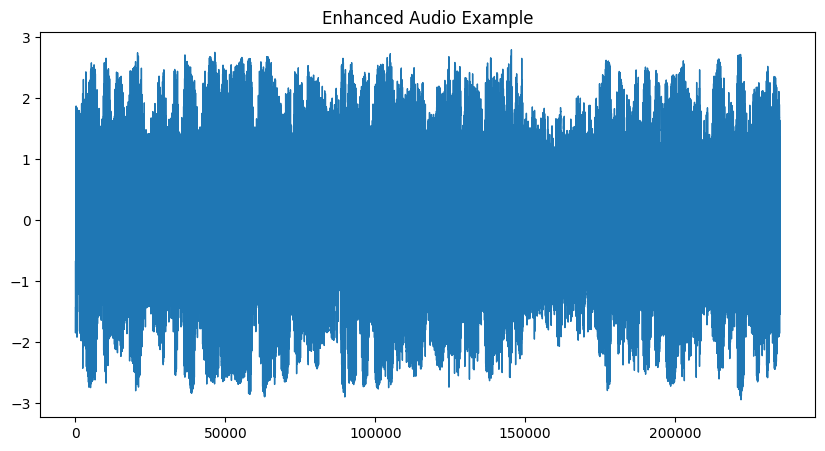

In [48]:
pd.Series(enhace_audio).plot(figsize=(10, 5), lw=1,title='Enhanced Audio Example')
plt.show()

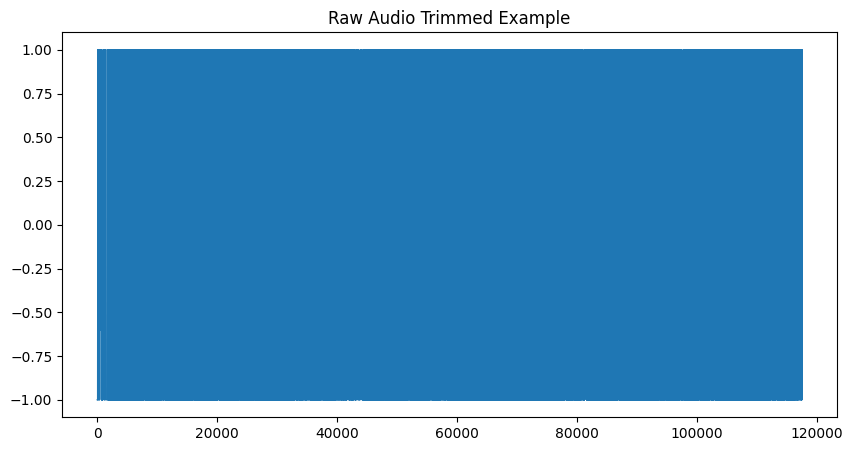

In [49]:
y_trimmed, _ = librosa.effects.trim(input_audio, top_db=20)
pd.Series(y_trimmed).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Trimmed Example')
plt.show()

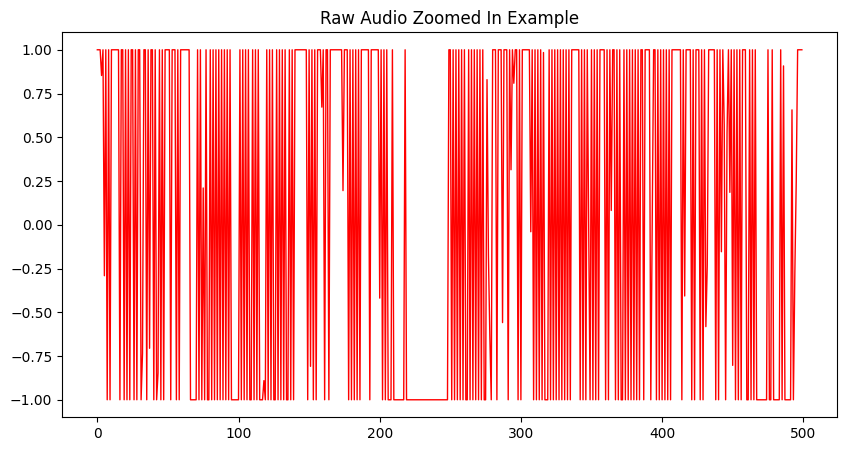

In [50]:
pd.Series(input_audio[30000:30500]).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Zoomed In Example',
                  color='red')
plt.show()

In [51]:
D = librosa.stft(input_audio)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
S_db.shape

(1025, 230)

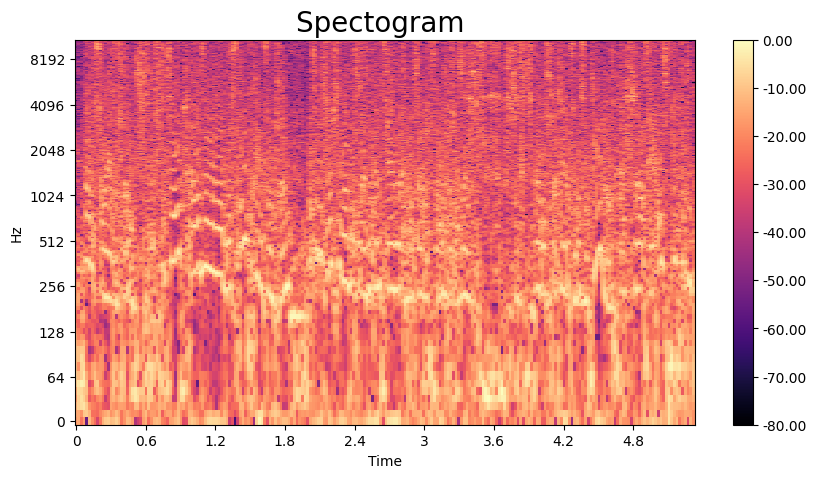

In [52]:
# Plot the transformed audio data
fig, ax = plt.subplots(figsize=(10, 5))
img = librosa.display.specshow(S_db,
                              x_axis='time',
                              y_axis='log',
                              ax=ax)
ax.set_title('Spectogram ', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

In [53]:
S = librosa.feature.melspectrogram(y=input_audio,
                                   sr=sr,
                                   n_mels=128 * 2,)
S_db_mel = librosa.amplitude_to_db(S, ref=np.max)

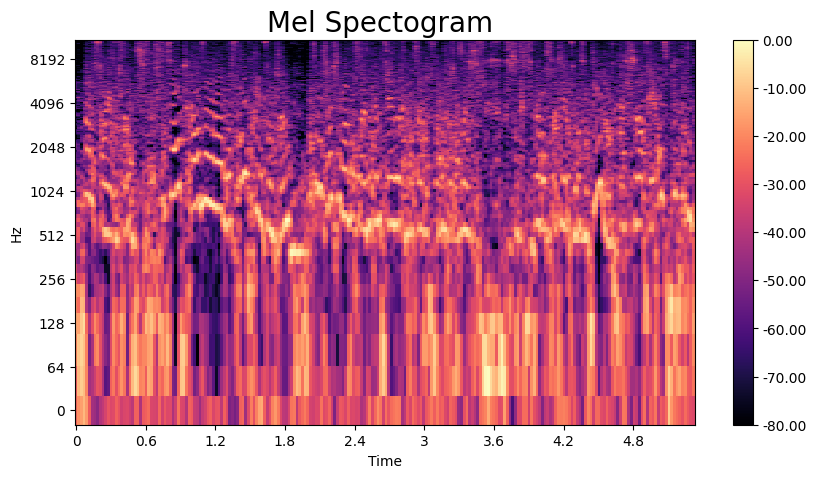

In [54]:
fig, ax = plt.subplots(figsize=(10, 5))
# Plot the mel spectogram
img = librosa.display.specshow(S_db_mel,
                              x_axis='time',
                              y_axis='log',
                              ax=ax)
ax.set_title('Mel Spectogram ', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()